---
---
>>>>>>>>> # بِسْمِ اللَّهِ الرَّحْمَنِ الرَّحِيم
---
---

# **<u>Master's Thesis</u>**
> - **Date:** *2023.09.01*
> - **Version:** *2.1*
>> - **Prepared by** *Shama Satter*
>> - **Supervised by** *KDK*

# **<u>Initialize Cloud-AI Engine</u>**
> Selected Python version: 3.9.13
>> To access the command line: `py -3.9 -m pip ...`
>>> - Upgrade pip: `py -3.9 -m pip install --upgrade pip`
>>> - Install TensorFlow-GPU (version <2.10): `py -3.9 -m pip install "tensorflow-gpu<2.10"`
>>> - Install TensorFlow Addons (version 0.19.0): `py -3.9 -m pip install tensorflow-addons==0.19.0` [GitHub link](https://github.com/tensorflow/addons)


>>> Install/Verify Packages

In [1]:
# %pip install --user --upgrade pandas
# %pip install --user --upgrade "sqlalchemy<2.0"
# %pip install --user --upgrade mariadb
# %pip install --user --upgrade -U matplotlib
# %pip install --user openpyxl
# %pip install --user xlrd
# %pip install --user joblib

>>> <b><u>Random Forest with Tree Selection Monte Carlo Based (RF-TSMC)</u></b> [link](https://pypi.org/project/random-forest-mc/)
>>>> This project is about use Random Forest approach for multiclass classification using a dynamic tree selection Monte Carlo based. The first implementation is found in [2] (using Common Lisp).
>>>>> This version of Random Forest makes the selection of trees based on indirect optimization via Monte Carlo simulations. Highly robust against unbalance between classes and missing data (for training and prediction). Optimized for training in parallel processing. Merge native between separate trained models, with simple merge or optimized; thus new models can be mixed with old models generating mixed models (mixing of decision trees), reducing possible new data vieses. This model is highly recommended for EDAs, because it offers a high degree of explainability for PoCs, as it has an excellent relationship between generalization and cost of training and maintenance. Already validated in production, with real data, for churn prediction, with data in the form of time series. In addition, it is excellent for studying Python, because the model is 100% Python code, using some of the most pytonic features! Inspect the code and enjoy!

In [2]:
# %pip install --user -U scikit-learn
# %pip install --user xgboost
# %pip install --user catboost
# %pip install --user lightgbm
# %pip install --user random-forest-mc

>>> Import Libraries

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import sqlalchemy
import mariadb
from matplotlib import pyplot as plt

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
import pickle

import tensorflow as tf
from keras import backend
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Bidirectional, GRU, Conv1D
from keras.layers import Concatenate, Dropout, BatchNormalization, Reshape, Flatten
from keras.layers import MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow_addons.layers import MultiHeadAttention
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt

from joblib import dump, load

from collections import defaultdict
from copy import deepcopy
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# __<u>Configure Simulation Setup</u>__

>>> Define `data, model and figure` directory

In [4]:
bigFileDirectory    =   '../BigFile/'
rawDataDirectory    = 'Data/Raw/'
dataDirectory       = 'Data/V1.1/'
modelDirectory      = 'Model/V1.1/'
figureDirectory     = 'Figure/V1.1/'

# create bigDataDirectory directory if it doesn't exist
if not os.path.exists(bigFileDirectory):
    os.makedirs(bigFileDirectory)
    print(f"System has created \"{bigFileDirectory}\" directory.")
else:
    print(f"The directory \"{bigFileDirectory}\" already exists.")

# create rawDataDirectory directory if it doesn't exist
if not os.path.exists(rawDataDirectory):
    os.makedirs(rawDataDirectory)
    print(f"System has created \"{rawDataDirectory}\" directory.")
else:
    print(f"The directory \"{rawDataDirectory}\" already exists.")

# create dataDirectory directory if it doesn't exist
if not os.path.exists(dataDirectory):
    os.makedirs(dataDirectory)
    print(f"System has created \"{dataDirectory}\" directory.")
else:
    print(f"The directory \"{dataDirectory}\" already exists.")

# create modelDirectory directory if it doesn't exist
if not os.path.exists(modelDirectory):
    os.makedirs(modelDirectory)
    print(f"System has created \"{modelDirectory}\" directory.")
else:
    print(f"The directory \"{modelDirectory}\" already exists.")


# create figureDirectory directory if it doesn't exist
if not os.path.exists(figureDirectory):
    os.makedirs(figureDirectory)
    print(f"System has created \"{figureDirectory}\" directory.")
else:
    print(f"The directory \"{figureDirectory}\" already exists.")

The directory "../BigFile/" already exists.
The directory "Data/Raw/" already exists.
The directory "Data/V1.1/" already exists.
The directory "Model/V1.1/" already exists.
The directory "Figure/V1.1/" already exists.


>>> Define columns and rows of pandas output

In [5]:
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 30)

>>> <u>GPU Configuration for AI Model Running</u>
>>>> To optimize GPU utilization for AI models, we have considered the following options:
>>>> 1. Limiting GPU Memory Growth [TensorFlow Guide](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth)
>>>> 2. Utilizing Multiple GPUs [TensorFlow Guide](https://www.tensorflow.org/guide/gpu#using_multiple_gpus)
>>>> 3. Running on a Single GPU in a Multi-GPU System [TensorFlow Guide](https://www.tensorflow.org/guide/gpu#using_a_single_gpu_on_a_multi-gpu_system)


In [6]:
### Limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print('Available Physical GPUs=>'+str(gpus))
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print('Configured Logical GPUs=>'+str(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Available Physical GPUs=>[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Configured Logical GPUs=>[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


>>> Specify the GPU that will be used for model execution

In [7]:
selectGPU   = 0
selectedGPU ='/device:GPU:'+ str(selectGPU)
selectedGPU

'/device:GPU:0'

# __<u>Data Preprocessing & Analysis</u>__

> ## <u>Creating DataFrame from the `.csv` files in the `Data\Raw\` directory </u>
>> We load individual DataFrame considering only `BE` or `Before Eating`

In [8]:
import pandas as pd
import os
import re

# Directory path
path = 'Data/Raw/'

# Counter for dataframe naming
df_counter = 1

# Iterate through each csv file in the directory
for file in sorted(os.listdir(path)):
    if file.endswith('.csv') and "BE" in file:
        # Extract details using regex
        match = re.match(r'(\d{4}.\d{2}.\d{2})-(\w+)-(\w+)-(\d+)mgdL.csv', file)

        if match:
            date, subject, meal_status, glucose_level = match.groups()

            # Read csv into dataframe
            df = pd.read_csv(os.path.join(path, file))

            # Rename the first three columns
            columns = df.columns.tolist()
            rename_dict = {columns[0]: "R", columns[1]: "G", columns[2]: "B"}
            df.rename(columns=rename_dict, inplace=True)

            # Drop the unwanted columns
            df.drop(columns=columns[3:6], inplace=True)

            # Add extracted columns to dataframe
            df['Date'] = date
            df['Subject Name'] = subject
            df['Meal Status'] = meal_status
            df['Glucose Level (mg/dL)'] = int(glucose_level)

            # Reorder columns
            cols_order = ['Date', 'Subject Name', 'Meal Status', 'Glucose Level (mg/dL)', 'R', 'G', 'B']
            df = df[cols_order]

            # Assign to global variable dynamically
            globals()[f'df_{df_counter}'] = df
            df_counter += 1

# After processing all files, print the summary
print(f"{df_counter - 1} dataframes were prepared, named from df_1 to df_{df_counter - 1}.")

25 dataframes were prepared, named from df_1 to df_25.


In [9]:
# Assuming df_counter holds the number of main dataframes created in the previous code

window_size = 24 * 30  # 30 seconds interval

# Loop through each main dataframe
for i in range(1, df_counter):
    main_df = globals()[f'df_{i}']
    num_windows = int(len(main_df) / window_size)
    
    # Loop to create sub-dataframes
    for j in range(num_windows):
        start_idx   = j * window_size
        end_idx     = start_idx + window_size
        
        sub_df      = main_df.iloc[start_idx:end_idx]
        
        # Assign the sub dataframe to a dynamic global variable
        globals()[f'df_{i}_{j+1}'] = sub_df
        
        # Print the range of indices for the sub-dataframe
        # print(f'df_{i}_{j+1} range in df_{i}: {start_idx} to {end_idx - 1}')  # -1 to get the last index in the window

        print(f'df_{i}_{j+1}')  # -1 to get the last index in the window

# After this loop, you'll have dataframes named df_1_1, df_1_2,..., df_2_1, df_2_2, and so on. You'll also have printed out the range of indices from the main df_X for each sub-dataframe.

df_1_1
df_1_2
df_1_3
df_1_4
df_1_5
df_1_6
df_1_7
df_1_8
df_1_9
df_1_10
df_2_1
df_2_2
df_2_3
df_2_4
df_2_5
df_2_6
df_2_7
df_3_1
df_3_2
df_3_3
df_3_4
df_3_5
df_3_6
df_3_7
df_3_8
df_3_9
df_3_10
df_4_1
df_4_2
df_4_3
df_4_4
df_4_5
df_4_6
df_4_7
df_4_8
df_5_1
df_5_2
df_5_3
df_5_4
df_5_5
df_5_6
df_5_7
df_5_8
df_5_9
df_5_10
df_5_11
df_5_12
df_6_1
df_6_2
df_6_3
df_6_4
df_6_5
df_6_6
df_6_7
df_6_8
df_6_9
df_6_10
df_6_11
df_7_1
df_7_2
df_7_3
df_7_4
df_7_5
df_7_6
df_7_7
df_7_8
df_7_9
df_7_10
df_7_11
df_7_12
df_7_13
df_8_1
df_8_2
df_8_3
df_8_4
df_8_5
df_8_6
df_8_7
df_8_8
df_8_9
df_8_10
df_8_11
df_8_12
df_9_1
df_9_2
df_9_3
df_9_4
df_9_5
df_9_6
df_9_7
df_9_8
df_9_9
df_9_10
df_9_11
df_9_12
df_9_13
df_10_1
df_10_2
df_10_3
df_10_4
df_10_5
df_10_6
df_10_7
df_10_8
df_10_9
df_10_10
df_10_11
df_10_12
df_11_1
df_11_2
df_11_3
df_11_4
df_11_5
df_11_6
df_11_7
df_11_8
df_11_9
df_11_10
df_11_11
df_12_1
df_12_2
df_12_3
df_12_4
df_12_5
df_12_6
df_12_7
df_12_8
df_12_9
df_12_10
df_12_11
df_12_12
df_13_1
df_13_2
df_13_

In [10]:
import numpy as np

# Determine the highest index for which the corresponding DataFrame exists
highest_index_x = 1
highest_index_y = 1

while True:
    if f'df_{highest_index_x}_{highest_index_y}' in globals():
        highest_index_y += 1
    else:
        if highest_index_y == 1:
            break
        highest_index_x += 1
        highest_index_y = 1

highest_index_x -= 1  # Adjust since we added 1 extra in the loop

# For each primary index (x), collect all secondary indexed DataFrames (y) into a list
# Then, process that list to produce a combined numpy array which is saved as subject_x
for x in range(1, highest_index_x + 1):
    dfs = []
    y = 1
    while True:
        df_name = f'df_{x}_{y}'
        if df_name in globals():
            dfs.append(globals()[df_name])
            y += 1
        else:
            break

    # Remove specified columns and convert to NumPy arrays
    np_arrays = [df.drop(['Date', 'Subject Name', 'Meal Status'], axis=1).to_numpy() for df in dfs]

    # Combine the NumPy arrays along a new axis
    globals()[f'subject_{x}'] = np.stack(np_arrays)

    # Print the resulting combined NumPy array shape
    print(f"subject_{x}.shape:", globals()[f'subject_{x}'].shape)

subject_1.shape: (10, 720, 4)
subject_2.shape: (7, 720, 4)
subject_3.shape: (10, 720, 4)
subject_4.shape: (8, 720, 4)
subject_5.shape: (12, 720, 4)
subject_6.shape: (11, 720, 4)
subject_7.shape: (13, 720, 4)
subject_8.shape: (12, 720, 4)
subject_9.shape: (13, 720, 4)
subject_10.shape: (12, 720, 4)
subject_11.shape: (11, 720, 4)
subject_12.shape: (12, 720, 4)
subject_13.shape: (12, 720, 4)
subject_14.shape: (11, 720, 4)
subject_15.shape: (11, 720, 4)
subject_16.shape: (11, 720, 4)
subject_17.shape: (12, 720, 4)
subject_18.shape: (14, 720, 4)
subject_19.shape: (6, 720, 4)
subject_20.shape: (7, 720, 4)
subject_21.shape: (7, 720, 4)
subject_22.shape: (7, 720, 4)
subject_23.shape: (7, 720, 4)
subject_24.shape: (7, 720, 4)
subject_25.shape: (7, 720, 4)


In [11]:
# List to store all subjects' arrays
all_subjects = []

# Loop through each subject's array and append it to the list
for x in range(1, highest_index_x + 1):
    subject_name = f'subject_{x}'
    if subject_name in globals():
        all_subjects.append(globals()[subject_name])

# Convert the list of arrays into a single three-dimensional array
combined_subjects_array = np.concatenate(all_subjects, axis=0)

# Print the shape of the combined array
print(combined_subjects_array.shape)

(250, 720, 4)


In [12]:
combined_subjects_array[0,0]

array([ 102., 4716., 4836., 4792.])

# __<u>Feature Extraction from PPG</u>__

>> **Note:**
>>   * <u>Summary of the Pre-processed data</u>
>>      * **Sampling Rate**: `24`
>>      * **Duration Test**: `30 sec`
>>      * **CBG (mg / dl)**: `capillary blood glucose`
>
> ## <u> The test and train datasets are prepared as follows: </u>
> 1. Defined a range of subjects from `1 to 9`. This implies we have data from 9 subjects.
> 2. For each subject, data is loaded from files named in the pattern `subject_{subject_number}.gzip`.
> 3. Using the function `feature_n_target_from_one_subject(file_name)`, data is extracted into two separate arrays: `featureMatrix` which contains the features, and `targetVector` which contains the target values.
> 4. The first `7` subjects' data are used for **training**, and the data from the last `2` subjects are used for **testing**.
> 5. All the training datasets (from different subjects) are vertically stacked to create a combined `X_train` and `y_train`. Similarly, the testing datasets are combined to form `X_test` and `y_test`.
> 6. All the datasets (both training and testing) are then combined into a single `X_all` and `y_all` for scaling.
> 7. A `MinMaxScaler` is applied to the combined dataset, and the scaler is saved as `Xy_scaler_model.joblib` for future use.
> 8. The scaled data is then split back into its original structure (`X_train`, `y_train`, `X_test`, and `y_test`).


In [16]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd

def process_signal(PPGnpArray, showFigure=False):
    # Define the filter parameters
    fs = 24  # sampling frequency
    low_cutoff = 3.0  # 3.0 to 4.0

    # Create the low pass filter
    sos = scipy.signal.butter(N=2, Wn=low_cutoff, btype='low', fs=fs, output='sos')

    # Extract the PPG data
    rs = PPGnpArray[:, 1]
    gs = PPGnpArray[:, 2]
    bs = PPGnpArray[:, 3]

    # Define a function to remove baseline drift using polynomial fitting
    def polynomial_detrend(data, degree=3):
        x = np.arange(len(data))
        fit = np.polyfit(x, data, degree)
        baseline = np.polyval(fit, x)
        return data - baseline

    # Remove baseline drift using polynomial fitting
    rs_detrended = polynomial_detrend(rs)
    gs_detrended = polynomial_detrend(gs)
    bs_detrended = polynomial_detrend(bs)

    # Filter the detrended data
    rs_filtered = scipy.signal.sosfilt(sos, rs_detrended)
    gs_filtered = scipy.signal.sosfilt(sos, gs_detrended)
    bs_filtered = scipy.signal.sosfilt(sos, bs_detrended)

    # Visualization
    if showFigure:
        colors = [('lightcoral', 'red', 'darkred'), ('lightgreen', 'green', 'darkgreen'), ('lightblue', 'blue', 'darkblue')]
        titles = ['Red', 'Green', 'Blue']
        signals = [(rs, rs_detrended, rs_filtered), (gs, gs_detrended, gs_filtered), (bs, bs_detrended, bs_filtered)]
        
        for color, title, signal in zip(colors, titles, signals):
            print(f'***************{title}**************')
            plt.rcParams.update(plt.rcParamsDefault)
            plt.rcParams['font.size'] = '9'
            fig, axs = plt.subplots(3, figsize=(18, 6))
            
            axs[0].set(title='Original PPG Signal')
            axs[0].plot(pd.DataFrame(signal[0]), color=color[0], label='Original')
            axs[0].set(ylabel=' ', xlabel=' ')
            axs[0].legend(loc=1)
            axs[0].grid(True)
            
            axs[1].set(title='After Baseline Drift Removal')
            axs[1].plot(pd.DataFrame(signal[1]), color=color[1], label='Detrended')
            axs[1].set(ylabel=' ', xlabel=' ')
            axs[1].legend(loc=1)
            axs[1].grid(True)
            
            axs[2].set(title='After Filtering the Detrended Signal')
            axs[2].plot(pd.DataFrame(signal[2]), color=color[2], label='Filtered')
            axs[2].set(ylabel=' ', xlabel=' ')
            axs[2].legend(loc=1)
            axs[2].grid(True)
            
            plt.tight_layout()
            plt.show()

    return rs_filtered, gs_filtered, bs_filtered

In [18]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd

def process_signal(PPGnpArray, showFigure=False):
    # Define the filter parameters
    fs = 24  # sampling frequency
    low_cutoff = 3.0  # 3.0 to 4.0

    # Create the low pass filter
    sos = scipy.signal.butter(N=2, Wn=low_cutoff, btype='low', fs=fs, output='sos')

    # Extract the PPG data
    rs = PPGnpArray[:, 1]
    gs = PPGnpArray[:, 2]
    bs = PPGnpArray[:, 3]

    # Define a function to remove baseline drift using polynomial fitting
    def polynomial_detrend(data, degree=3):
        x = np.arange(len(data))
        fit = np.polyfit(x, data, degree)
        baseline = np.polyval(fit, x)
        return data - baseline

    # Remove baseline drift using polynomial fitting
    rs_detrended = polynomial_detrend(rs)
    gs_detrended = polynomial_detrend(gs)
    bs_detrended = polynomial_detrend(bs)

    # Filter the detrended data
    rs_filtered = scipy.signal.sosfilt(sos, rs_detrended)
    gs_filtered = scipy.signal.sosfilt(sos, gs_detrended)
    bs_filtered = scipy.signal.sosfilt(sos, bs_detrended)

    # Remove baseline drift again from the filtered data
    rs_final = polynomial_detrend(rs_filtered)
    gs_final = polynomial_detrend(gs_filtered)
    bs_final = polynomial_detrend(bs_filtered)

    # Visualization
    if showFigure:
        colors = [('lightcoral', 'red', 'darkred'), ('lightgreen', 'green', 'darkgreen'), ('lightblue', 'blue', 'darkblue')]
        titles = ['Red', 'Green', 'Blue']
        signals = [(rs, rs_detrended, rs_filtered, rs_final), (gs, gs_detrended, gs_filtered, gs_final), (bs, bs_detrended, bs_filtered, bs_final)]
        
        for color, title, signal in zip(colors, titles, signals):
            print(f'***************{title}**************')
            plt.rcParams.update(plt.rcParamsDefault)
            plt.rcParams['font.size'] = '9'
            fig, axs = plt.subplots(4, figsize=(18, 8))
            
            axs[0].set(title='Original PPG Signal')
            axs[0].plot(pd.DataFrame(signal[0]), color=color[0], label='Original')
            axs[0].set(ylabel=' ', xlabel=' ')
            axs[0].legend(loc=1)
            axs[0].grid(True)
            
            axs[1].set(title='After Baseline Drift Removal')
            axs[1].plot(pd.DataFrame(signal[1]), color=color[1], label='Detrended')
            axs[1].set(ylabel=' ', xlabel=' ')
            axs[1].legend(loc=1)
            axs[1].grid(True)
            
            axs[2].set(title='After Filtering the Detrended Signal')
            axs[2].plot(pd.DataFrame(signal[2]), color=color[2], label='Filtered')
            axs[2].set(ylabel=' ', xlabel=' ')
            axs[2].legend(loc=1)
            axs[2].grid(True)

            axs[3].set(title='After Removing Baseline Drift Again from Filtered Signal')
            axs[3].plot(pd.DataFrame(signal[3]), color=color[2], label='Final Processed')
            axs[3].set(ylabel=' ', xlabel=' ')
            axs[3].legend(loc=1)
            axs[3].grid(True)
            
            plt.tight_layout()
            plt.show()

    return rs_final, gs_final, bs_final

In [24]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd

def process_signal(PPGnpArray, showFigure=False):
    # Define the filter parameters
    fs = 24  # sampling frequency
    low_cutoff  = 3.0  # 3.0 to 4.0
    high_cutoff = 0.2  # e.g., 0.5 Hz to remove drifts slower than 2 seconds

    # Create the low-pass filter
    sos_low = scipy.signal.butter(N=2, Wn=low_cutoff, btype='low', fs=fs, output='sos')
    # Create the high-pass filter
    sos_high = scipy.signal.butter(N=2, Wn=high_cutoff, btype='high', fs=fs, output='sos')

    # Extract the PPG data
    rs = PPGnpArray[:, 1]
    gs = PPGnpArray[:, 2]
    bs = PPGnpArray[:, 3]

    # Define a function to remove baseline drift using polynomial fitting
    def polynomial_detrend(data, degree=3):
        x = np.arange(len(data))
        fit = np.polyfit(x, data, degree)
        baseline = np.polyval(fit, x)
        return data - baseline

    # Remove baseline drift using polynomial fitting
    rs_detrended = polynomial_detrend(rs)
    gs_detrended = polynomial_detrend(gs)
    bs_detrended = polynomial_detrend(bs)

    # Filter the detrended data using low-pass filter
    rs_filtered = scipy.signal.sosfilt(sos_low, rs_detrended)
    gs_filtered = scipy.signal.sosfilt(sos_low, gs_detrended)
    bs_filtered = scipy.signal.sosfilt(sos_low, bs_detrended)

    # Remove baseline drift from filtered data using high-pass filter
    rs_final = scipy.signal.sosfilt(sos_high, rs_filtered)
    gs_final = scipy.signal.sosfilt(sos_high, gs_filtered)
    bs_final = scipy.signal.sosfilt(sos_high, bs_filtered)

    # Visualization
    if showFigure:
        colors = [('lightcoral', 'red', 'darkred'), ('lightgreen', 'green', 'darkgreen'), ('lightblue', 'blue', 'darkblue')]
        titles = ['Red', 'Green', 'Blue']
        signals = [(rs, rs_detrended, rs_filtered, rs_final), (gs, gs_detrended, gs_filtered, gs_final), (bs, bs_detrended, bs_filtered, bs_final)]
        
        for color, title, signal in zip(colors, titles, signals):
            print(f'***************{title}**************')
            plt.rcParams.update(plt.rcParamsDefault)
            plt.rcParams['font.size'] = '9'
            fig, axs = plt.subplots(4, figsize=(18, 8))
            
            axs[0].set(title='Original PPG Signal')
            axs[0].plot(pd.DataFrame(signal[0]), color=color[0], label='Original')
            axs[0].set(ylabel=' ', xlabel=' ')
            axs[0].legend(loc=1)
            axs[0].grid(True)
            
            axs[1].set(title='After Baseline Drift Removal using Polynomial Detrending')
            axs[1].plot(pd.DataFrame(signal[1]), color=color[1], label='Detrended')
            axs[1].set(ylabel=' ', xlabel=' ')
            axs[1].legend(loc=1)
            axs[1].grid(True)
            
            axs[2].set(title='After Filtering the Detrended Signal')
            axs[2].plot(pd.DataFrame(signal[2]), color=color[2], label='Filtered')
            axs[2].set(ylabel=' ', xlabel=' ')
            axs[2].legend(loc=1)
            axs[2].grid(True)

            axs[3].set(title='After Removing Baseline Drift from Filtered Signal using High-pass Filter')
            axs[3].plot(pd.DataFrame(signal[3]), color=color[2], label='Final Processed')
            axs[3].set(ylabel=' ', xlabel=' ')
            axs[3].legend(loc=1)
            axs[3].grid(True)
            
            plt.tight_layout()
            plt.show()

    return rs_final, gs_final, bs_final

***************Red**************


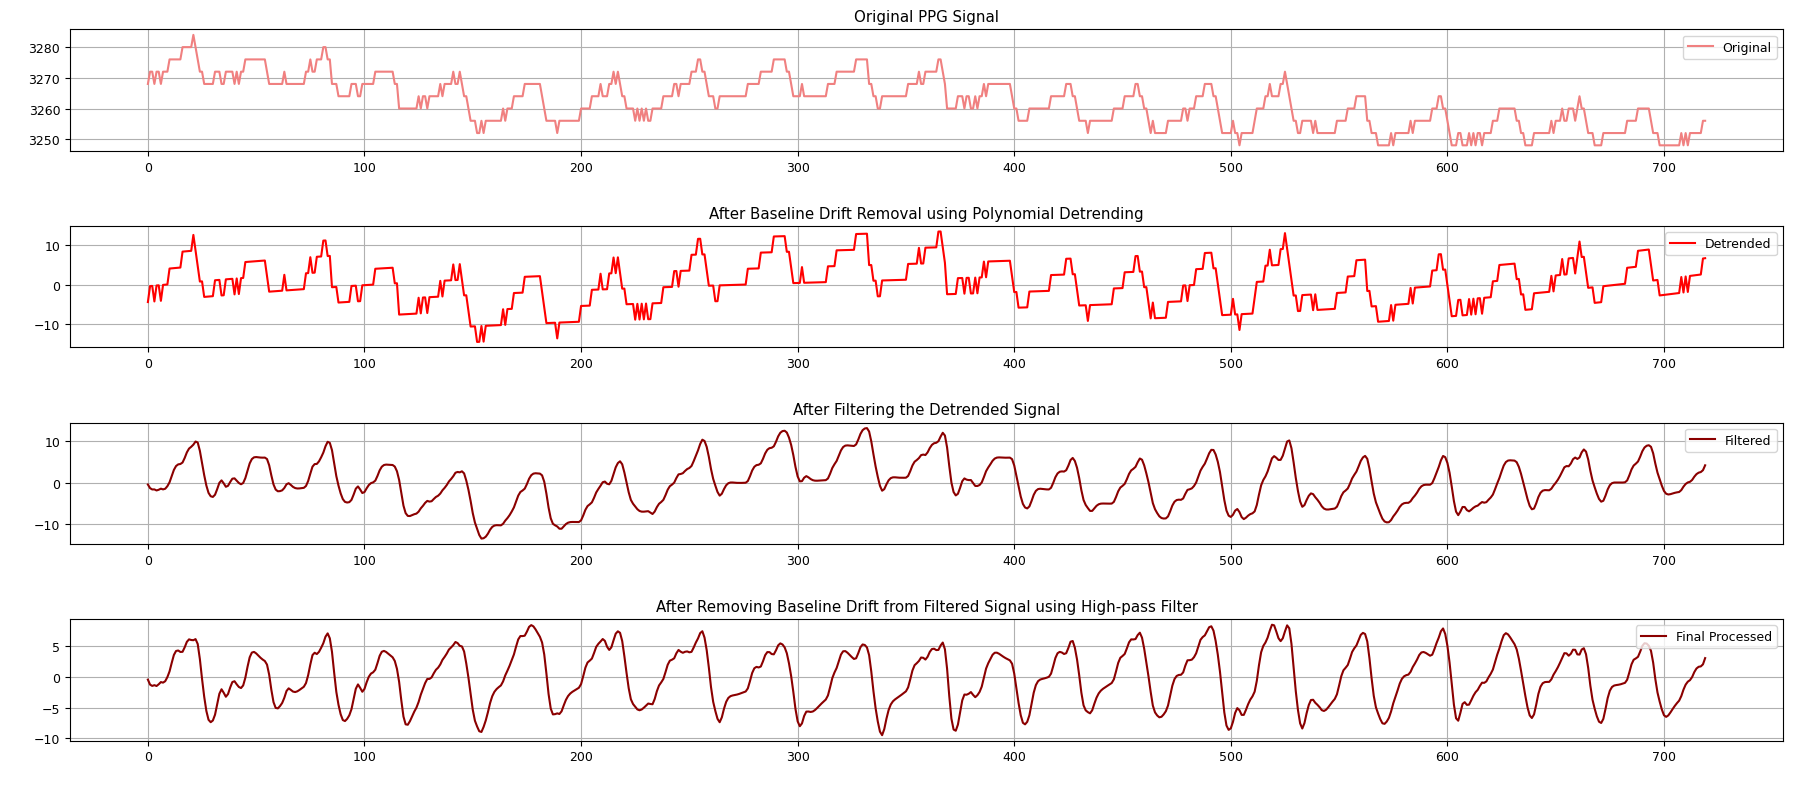

***************Green**************


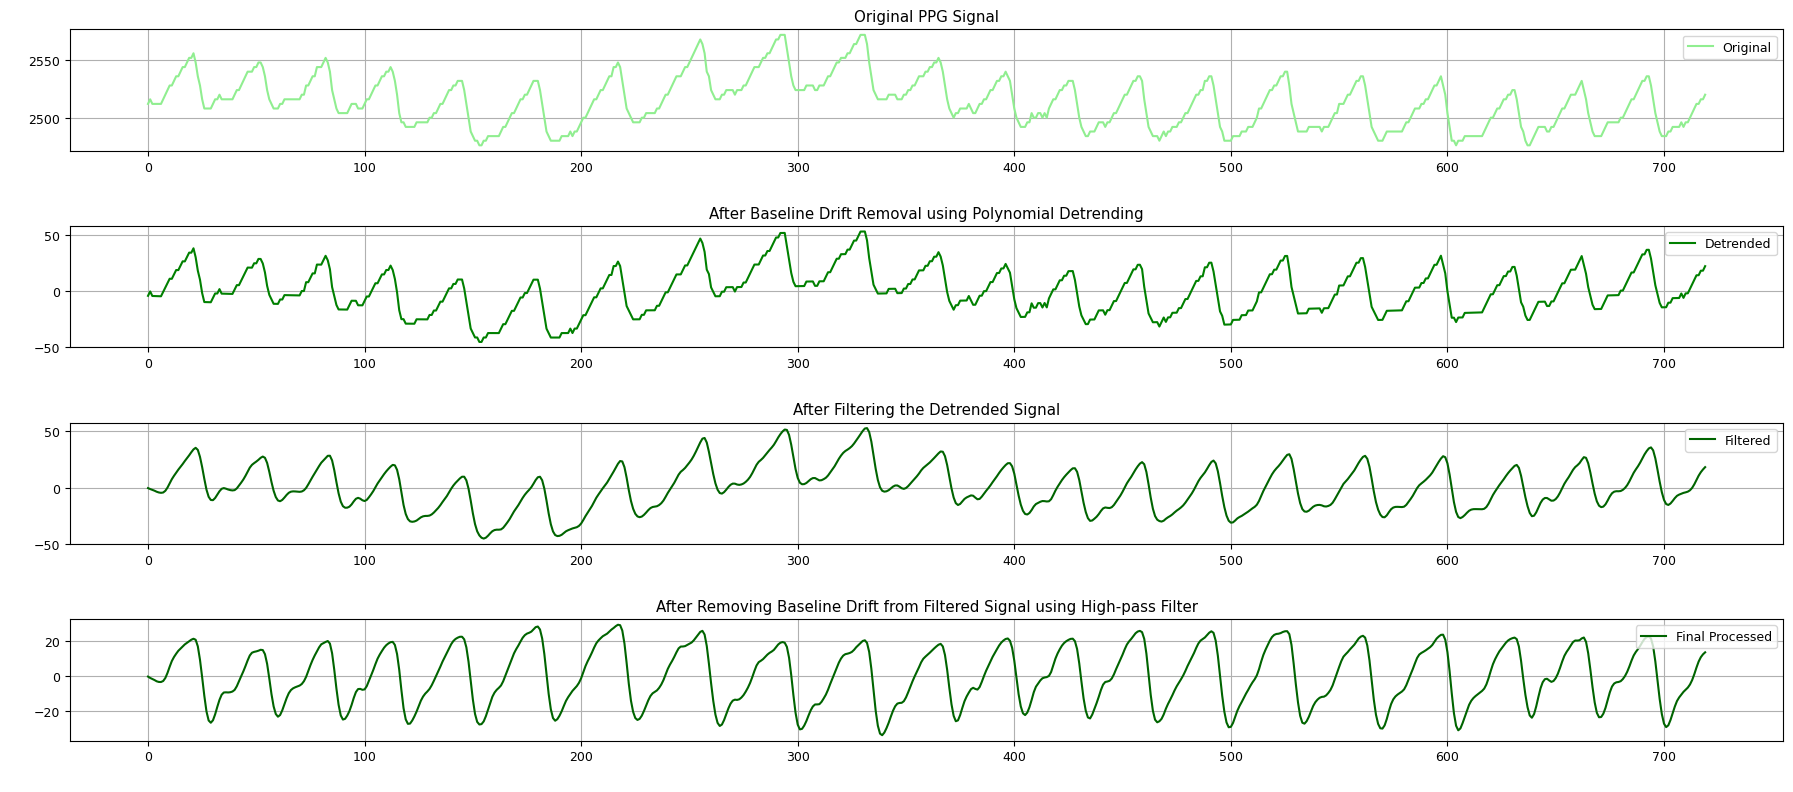

***************Blue**************


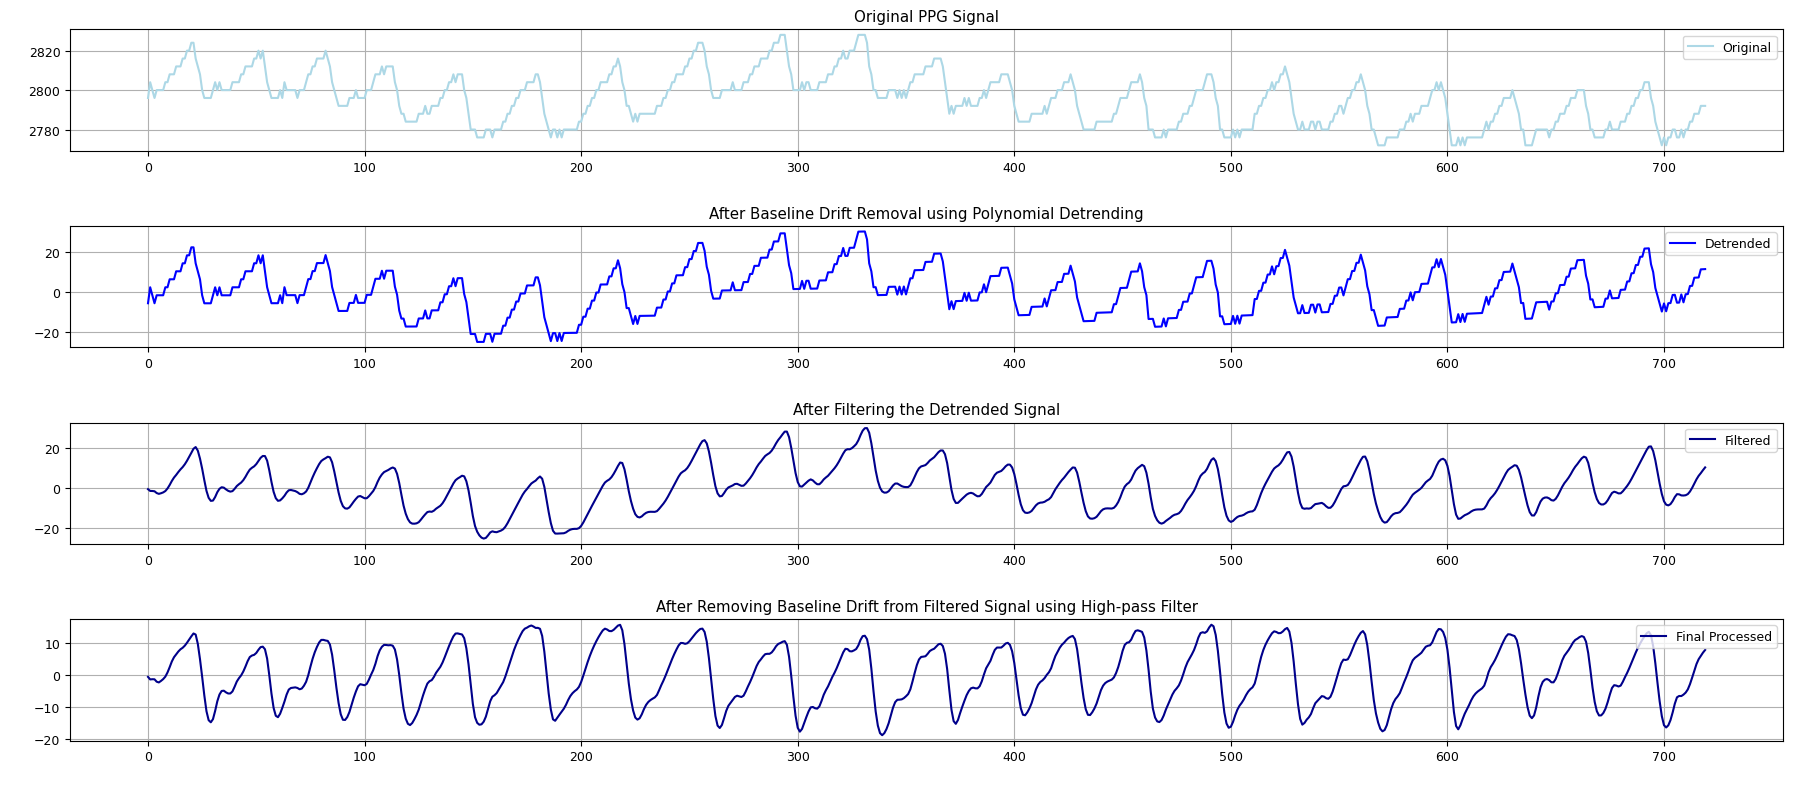

In [25]:
r,g,b = process_signal(combined_subjects_array[30], showFigure='True')

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal

def remove_baseline_and_filter(PPGnpArray, polynomial_degree=3, showFigure=False):
    # Extract the PPG data
    rs = PPGnpArray[:,1]
    gs = PPGnpArray[:,2]
    bs = PPGnpArray[:,3]
    
    fs          = 24  # sampling frequency
    low_cutoff  = 3.0  
    high_cutoff = 0.5  

    # Define filters
    sos  = scipy.signal.butter(N=2, Wn=low_cutoff,  btype='low',  fs=fs, output='sos')
    sos1 = scipy.signal.butter(N=2, Wn=high_cutoff, btype='high', fs=fs, output='sos')

    # Define a function to remove baseline drift using polynomial fitting
    def polynomial_detrend(data, degree):
        x = np.arange(len(data))
        fit = np.polyfit(x, data, degree)
        baseline = np.polyval(fit, x)
        return data - baseline

    # Apply polynomial detrending
    rs_detrended = polynomial_detrend(rs, polynomial_degree)
    gs_detrended = polynomial_detrend(gs, polynomial_degree)
    bs_detrended = polynomial_detrend(bs, polynomial_degree)

    # Filter the detrended data
    rs_filtered = scipy.signal.sosfilt(sos1, scipy.signal.sosfilt(sos, rs_detrended)) 
    gs_filtered = scipy.signal.sosfilt(sos1, scipy.signal.sosfilt(sos, gs_detrended)) 
    bs_filtered = scipy.signal.sosfilt(sos1, scipy.signal.sosfilt(sos, bs_detrended)) 

    # Visualization
    if showFigure:
        colors = [('red', 'darkred'), ('green', 'darkgreen'), ('blue', 'darkblue')]
        titles = ['Red', 'Green', 'Blue']
        signals = [(rs, rs_filtered), (gs, gs_filtered), (bs, bs_filtered)]
        
        for color, title, signal in zip(colors, titles, signals):
            print(f'***************{title}**************')
            plt.rcParams.update(plt.rcParamsDefault)
            plt.rcParams['font.size'] = '9'
            fig, axs = plt.subplots(2, figsize=(18, 4))
            
            axs[0].set(title='Visualization of PPG Signal before and after processing')
            axs[0].plot(pd.DataFrame(signal[0]), color=color[0], label='Original')
            axs[0].set(ylabel=' ', xlabel=' ')
            axs[0].legend(loc=1)
            axs[0].grid(True)
            
            axs[1].plot(pd.DataFrame(signal[1]), color=color[1], label='After detrending and filtering')
            axs[1].set(ylabel=' ', xlabel=' ')
            axs[1].legend(loc=1)
            axs[1].grid(True)
            
            plt.show()

    return rs_filtered, gs_filtered, bs_filtered

***************Red**************


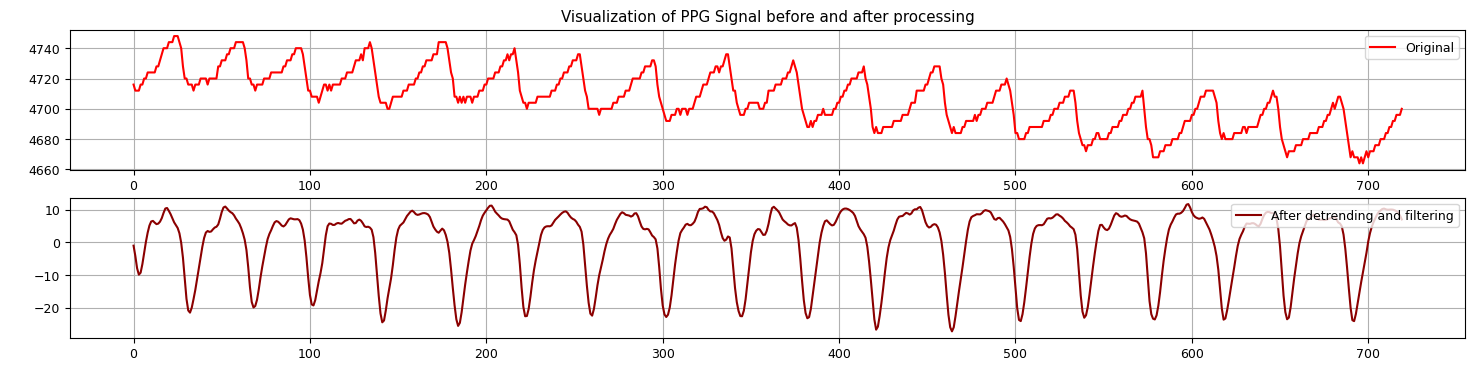

***************Green**************


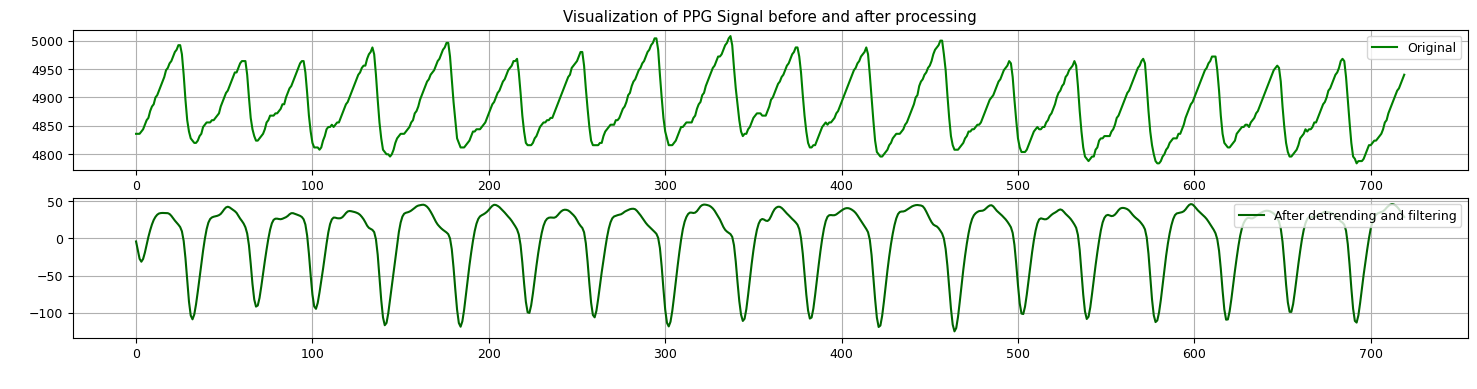

***************Blue**************


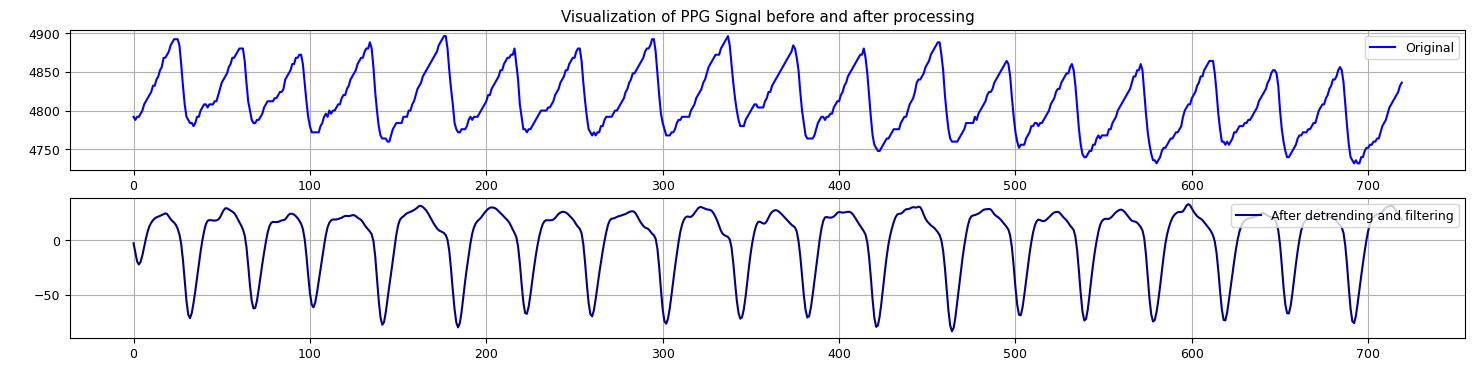

In [83]:
r,g,b = remove_baseline_and_filter(combined_subjects_array[0], showFigure='True')

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def remove_baseline_drift_poly(PPGnpArray, polynomial_degree=3, showFigure=False):
    # Extract the PPG data
    rs = PPGnpArray[:,1]
    gs = PPGnpArray[:,2]
    bs = PPGnpArray[:,3]

    # Define a function to remove baseline drift using polynomial fitting
    def polynomial_detrend(data, degree):
        x = np.arange(len(data))
        fit = np.polyfit(x, data, degree)
        baseline = np.polyval(fit, x)
        return data - baseline

    # Apply polynomial detrending
    rs_detrended = polynomial_detrend(rs, polynomial_degree)
    gs_detrended = polynomial_detrend(gs, polynomial_degree)
    bs_detrended = polynomial_detrend(bs, polynomial_degree)

    # Visualization
    if showFigure:
        colors = [('red', 'darkred'), ('green', 'darkgreen'), ('blue', 'darkblue')]
        titles = ['Red', 'Green', 'Blue']
        signals = [(rs, rs_detrended), (gs, gs_detrended), (bs, bs_detrended)]
        
        for color, title, signal in zip(colors, titles, signals):
            print(f'***************{title}**************')
            plt.rcParams.update(plt.rcParamsDefault)
            plt.rcParams['font.size'] = '9'
            fig, axs = plt.subplots(2, figsize=(18, 4))
            
            axs[0].set(title='Visualization of PPG Signal before and after detrending')
            axs[0].plot(pd.DataFrame(signal[0]), color=color[0], label='Original')
            axs[0].set(ylabel=' ', xlabel=' ')
            axs[0].legend(loc=1)
            axs[0].grid(True)
            
            axs[1].plot(pd.DataFrame(signal[1]), color=color[1], label='After baseline drift removal')
            axs[1].set(ylabel=' ', xlabel=' ')
            axs[1].legend(loc=1)
            axs[1].grid(True)
            
            plt.show()

    return rs_detrended, gs_detrended, bs_detrended


***************Red**************


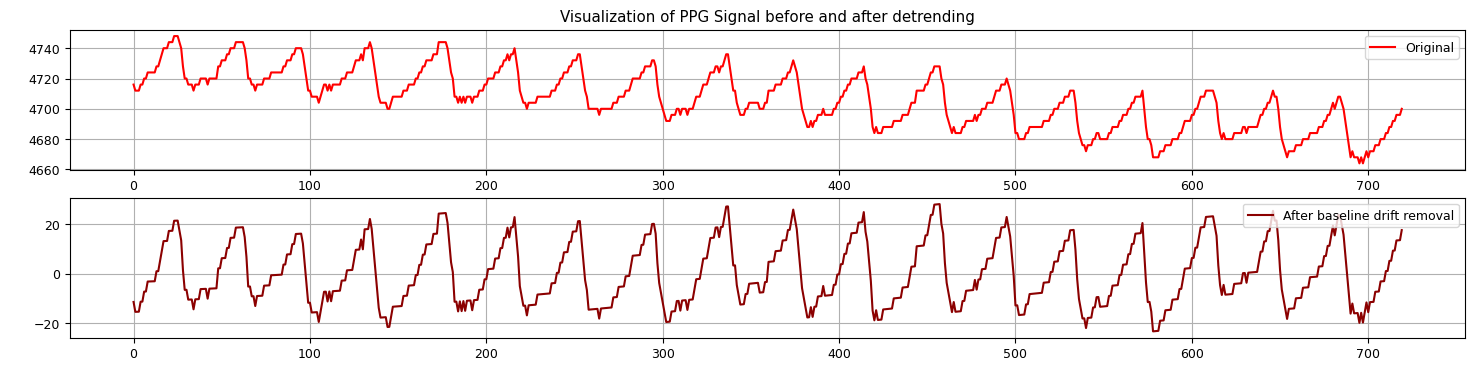

***************Green**************


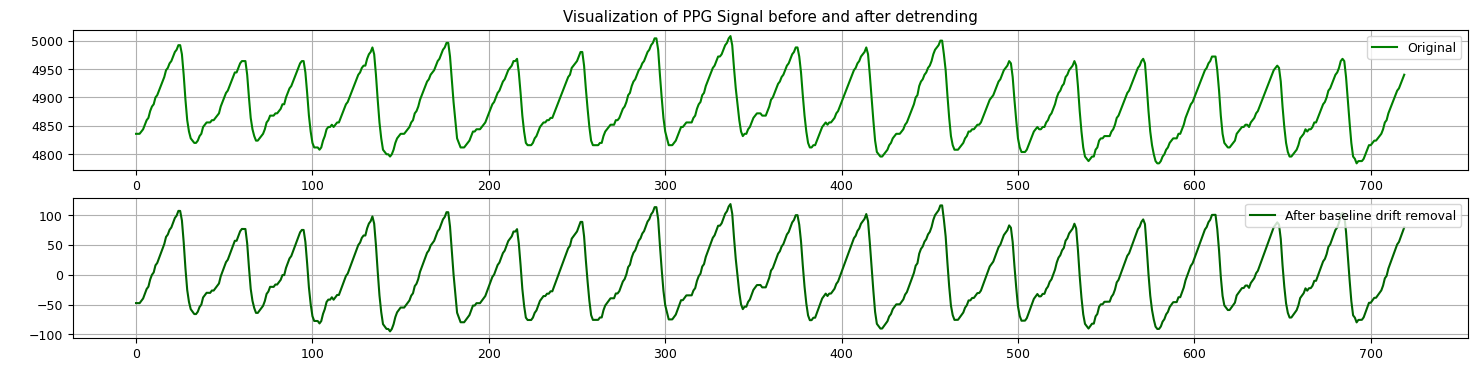

***************Blue**************


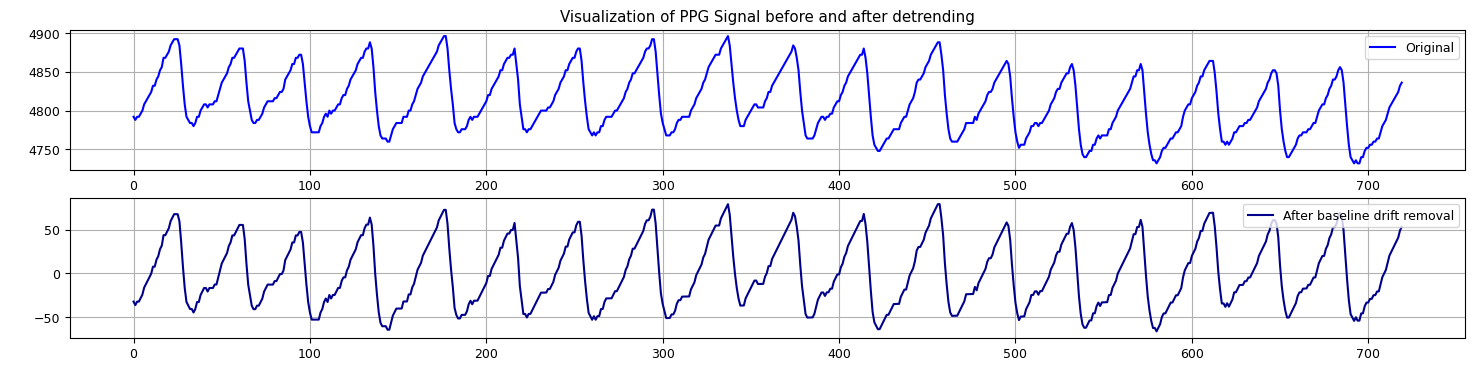

In [81]:
r,g,b = remove_baseline_drift_poly(combined_subjects_array[0], showFigure='True')

In [90]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd

def removing_baseline_drift(PPGnpArray, showFigure='False'):
    # Define the filter parameters
    fs            = 24   # sampling frequency
    low_cutoff    = 3.0  # 3.0 to 4.0
    high_cutoff   = 0.5  # or closer to 0.67 if you're particularly interested in capturing rates down to 40 bpm

    
    # Create the filters
    sos  = scipy.signal.butter(N=2, Wn=low_cutoff,  btype='low',  fs=fs, output='sos')
    sos1 = scipy.signal.butter(N=2, Wn=high_cutoff, btype='high', fs=fs, output='sos')

    # Extract the PPG data
    rs = PPGnpArray[:,1]
    gs = PPGnpArray[:,2]
    bs = PPGnpArray[:,3]

    # Filter the data
    fil_s_b = scipy.signal.sosfilt(sos, bs)
    fil_s_g = scipy.signal.sosfilt(sos, gs)
    fil_s_r = scipy.signal.sosfilt(sos, rs)

    fil_s_b1 = scipy.signal.sosfilt(sos1, fil_s_b) + np.mean(fil_s_b)
    fil_s_g1 = scipy.signal.sosfilt(sos1, fil_s_g) + np.mean(fil_s_g)
    fil_s_r1 = scipy.signal.sosfilt(sos1, fil_s_r) + np.mean(fil_s_r)

    # Truncate signals if required 
    transient_response_samples  = 12  # Set this based on filter's transient response.
    fil_s_b = fil_s_b[transient_response_samples:]
    fil_s_g = fil_s_g[transient_response_samples:]
    fil_s_r = fil_s_r[transient_response_samples:]
    
    transient_response_samples1 = 72  # Again, set this based on filter's transient response.
    fil_s_b1 = fil_s_b1[transient_response_samples1:]
    fil_s_g1 = fil_s_g1[transient_response_samples1:]
    fil_s_r1 = fil_s_r1[transient_response_samples1:]

    # Visualization
    if showFigure == 'True':
      print('***************Red**************')
      plt.rcParams.update(plt.rcParamsDefault)
      plt.rcParams['font.size'] = '9'
      fig,axs = plt.subplots(2, figsize=(20, 2.5))
      axs[0].set(title='Visualization of PPG Signal before and after filtering')
      axs[0].plot(pd.DataFrame(fil_s_r), color='red', label='after first filtering')
      axs[0].set(ylabel = ' ', xlabel = ' ')
      axs[0].legend(loc=1)
      axs[0].grid(True)
      axs[1].plot(pd.DataFrame(fil_s_r1), color='red', label='After 2nd filter and baseline_drift_removal')
      axs[1].set(ylabel = ' ', xlabel = ' ')
      axs[1].legend(loc=1)
      axs[1].grid(True)
      plt.show()

      print('***************Green**************')
      plt.rcParams.update(plt.rcParamsDefault)
      plt.rcParams['font.size'] = '9'
      fig,axs = plt.subplots(2, figsize=(20, 2.5))
      axs[0].set(title='Visualization of PPG Signal before and after filtering')
      axs[0].plot(pd.DataFrame(fil_s_g), color='green', label='after first filtering')
      axs[0].set(ylabel = ' ', xlabel = ' ')
      axs[0].legend(loc=1)
      axs[0].grid(True)
      axs[1].plot(pd.DataFrame(fil_s_g1), color='green', label='After 2nd filter and baseline_drift_removal')
      axs[1].set(ylabel = ' ', xlabel = ' ')
      axs[1].legend(loc=1)
      axs[1].grid(True)
      plt.show()

      print('***************Blue**************')
      plt.rcParams.update(plt.rcParamsDefault)
      plt.rcParams['font.size'] = '9'
      fig,axs = plt.subplots(2, figsize=(20, 2.5))
      axs[0].set(title='Visualization of PPG Signal before and after filtering')
      axs[0].plot(pd.DataFrame(fil_s_b), color='blue', label='after first filtering')
      axs[0].set(ylabel = ' ', xlabel = ' ')
      axs[0].legend(loc=1)
      axs[0].grid(True)
      axs[1].plot(pd.DataFrame(fil_s_b1), color='blue', label='After 2nd filter and baseline_drift_removal')
      axs[1].set(ylabel = ' ', xlabel = ' ')
      axs[1].legend(loc=1)
      axs[1].grid(True)
      plt.show()
      

    return fil_s_r1, fil_s_g1, fil_s_b1

***************Red**************


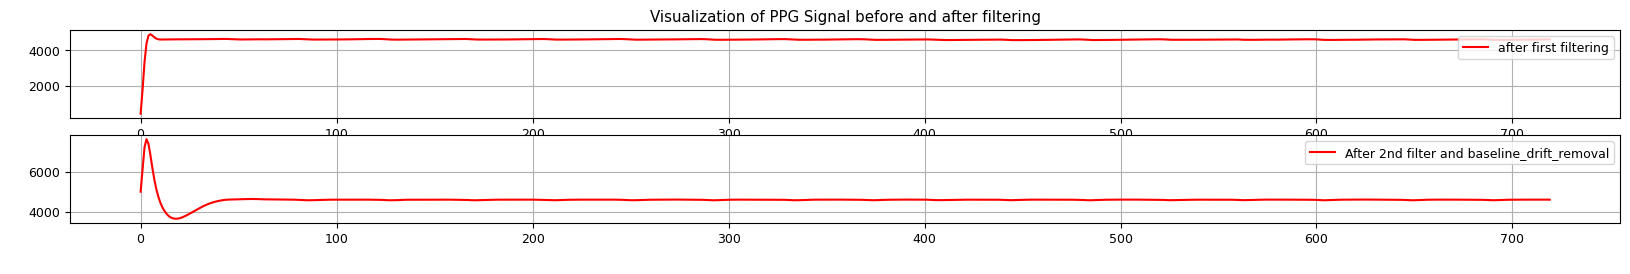

***************Green**************


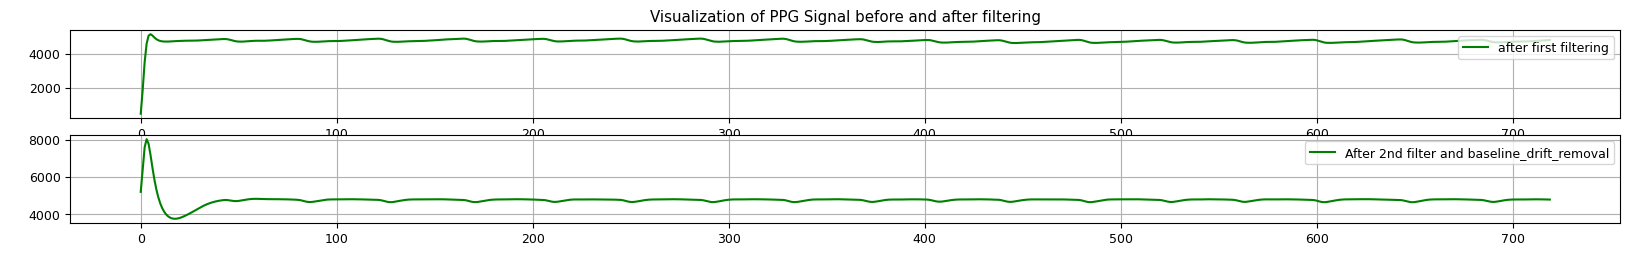

***************Blue**************


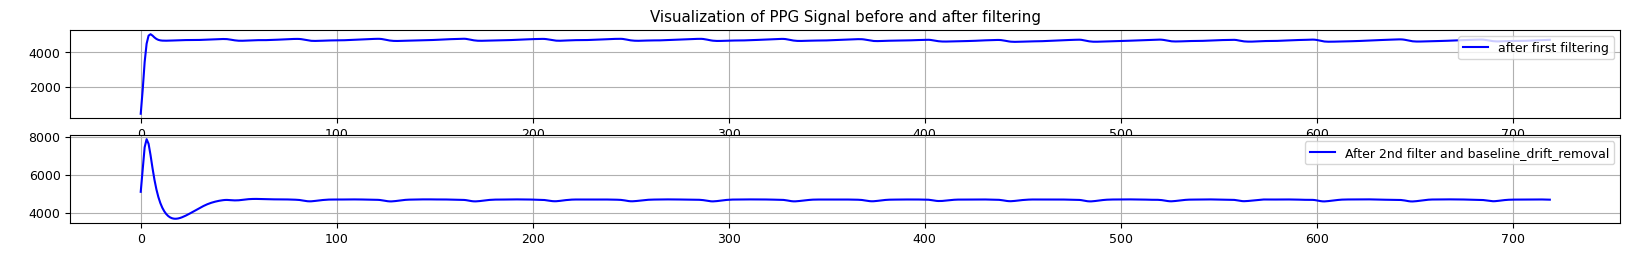

In [91]:
# > __Algorithm 01:__ Baseline Dirft Removal by () 
r,g,b = removing_baseline_drift(combined_subjects_array[3], showFigure='True')

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(170, 32)
(170,)
(44, 32)
(44,)


# __<u> Training ML Models </u>__
- Leave One Out Approach
- 4 Models : `RandomForest`, `XGBoost`, `CatBoost` & `LightGBM`

In [ ]:
# Define the models to be trained
models = {
    "RandomForest"  : RandomForestRegressor(),
    "XGBoost"       : XGBRegressor(),
    "CatBoost"      : CatBoostRegressor(verbose=0),
    "LightGBM"      : LGBMRegressor()
}

model_performances = defaultdict(list)
model_lists = defaultdict(list)

loo = LeaveOneOut()
num_epochs = loo.get_n_splits(X_train)

for model_name, base_model in models.items():
    mse_values_for_model = []

    for epoch, (train_idx, test_idx) in enumerate(loo.split(X_train), start=1):
        X_loo_train, X_loo_test = X_train[train_idx], X_train[test_idx]
        y_loo_train, y_loo_test = y_train[train_idx], y_train[test_idx]
        
        model = deepcopy(base_model)
        model.fit(X_loo_train, y_loo_train)
        
        y_loo_pred = model.predict(X_loo_test)
        mse_loo = mean_squared_error(y_loo_test, y_loo_pred)
        
        mse_values_for_model.append(mse_loo)
        model_lists[model_name].append(model)

        print(f"Training {model_name} - Epoch {epoch}/{num_epochs} - Current MSE: {mse_loo:.4f}", end="\r", flush=True)

    average_mse = sum(mse_values_for_model) / len(mse_values_for_model)
    model_performances[model_name].extend(mse_values_for_model)  # Store list of MSE values for each model
    
    print(f"\nAverage MSE for {model_name} with LOOCV: {average_mse:.4f}")
    print("-" * 50)

dump(model_performances,    f'{bigFileDirectory}model_performances.joblib')
dump(model_lists,           f'{bigFileDirectory}model_lists.joblib')

Training RandomForest - Epoch 170/170 - Current MSE: 0.0385
Average MSE for RandomForest with LOOCV: 0.0135
--------------------------------------------------
Training XGBoost - Epoch 170/170 - Current MSE: 0.0486
Average MSE for XGBoost with LOOCV: 0.0163
--------------------------------------------------
Training CatBoost - Epoch 170/170 - Current MSE: 0.0194
Average MSE for CatBoost with LOOCV: 0.0133
--------------------------------------------------
Training LightGBM - Epoch 170/170 - Current MSE: 0.0173
Average MSE for LightGBM with LOOCV: 0.0155
--------------------------------------------------


['../BigFile/model_lists.joblib']

# __<u>Innovation</u>__
- weighted_ensemble_predict

In [ ]:
model_performances  = load(f'{bigFileDirectory}model_performances.joblib')
model_lists         = load(f'{bigFileDirectory}model_lists.joblib')


def weighted_ensemble_predict(X, models, performances):
    total_weights = sum([1 / mse for mse in performances])
    predictions = np.zeros(X.shape[0])
    for model, mse in zip(models, performances):
        weight = (1 / mse) / total_weights
        predictions += weight * model.predict(X)
    return predictions


for model_type in models.keys():
    y_test_pred_ensemble = weighted_ensemble_predict(X_test, model_lists[model_type], model_performances[model_type])
    mse_ensemble = mean_squared_error(y_test, y_test_pred_ensemble)
    print(f"MSE in the Test Subjects using {model_type} ensemble: {mse_ensemble:.4f}")

MSE in the Test Subjects using RandomForest ensemble: 0.0125
MSE in the Test Subjects using XGBoost ensemble: 0.0114
MSE in the Test Subjects using CatBoost ensemble: 0.0130
MSE in the Test Subjects using LightGBM ensemble: 0.0140


# __<u>Evaluation</u>__

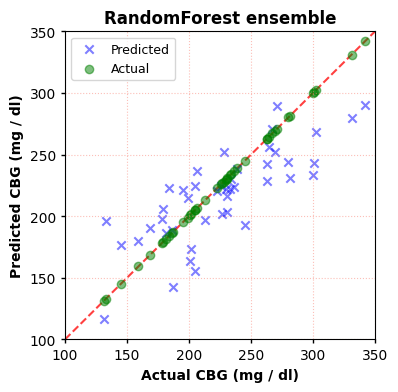

MAE in the Test Subjects using RandomForest ensemble: 25.9698
R^2 in the Test Subjects using RandomForest ensemble: 0.5889


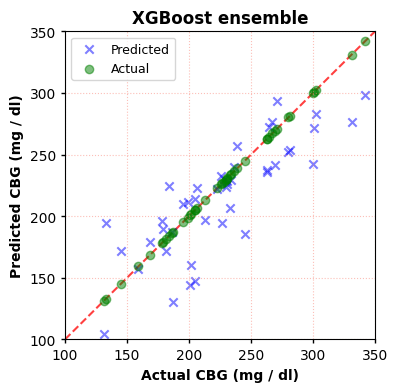

MAE in the Test Subjects using XGBoost ensemble: 23.5754
R^2 in the Test Subjects using XGBoost ensemble: 0.6256


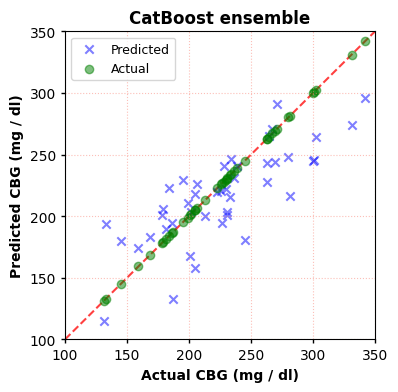

MAE in the Test Subjects using CatBoost ensemble: 26.0820
R^2 in the Test Subjects using CatBoost ensemble: 0.5709


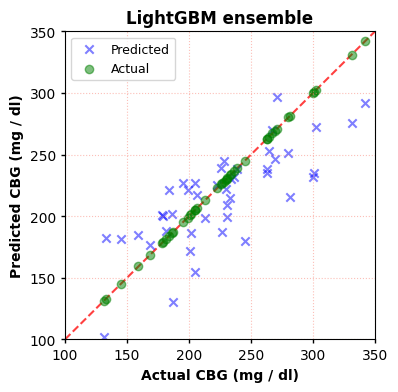

MAE in the Test Subjects using LightGBM ensemble: 27.4880
R^2 in the Test Subjects using LightGBM ensemble: 0.5396


In [ ]:
import numpy as np
from joblib import load

# Load the saved scaler
scaler = load(f'{modelDirectory}Xy_scaler_model.joblib')

def inverse_scale_target(scaler, y_scaled):
    # Create a dummy array with zeros with the same shape as the original dataset
    dummy = np.zeros((len(y_scaled), X_train.shape[1]+1))
    
    # Replace the last column (target values) with the scaled values
    dummy[:,-1] = y_scaled
    
    # Use inverse_transform to scale back to the original range
    y_original = scaler.inverse_transform(dummy)[:,-1]
    
    return y_original

for model_type in models.keys():
    y_test_pred_ensemble = weighted_ensemble_predict(X_test, model_lists[model_type], model_performances[model_type])
    
    # Convert the scaled predicted and actual values to their original values
    y_test_original                 = inverse_scale_target(scaler, y_test)
    y_test_pred_ensemble_original   = inverse_scale_target(scaler, y_test_pred_ensemble)
    
    # Scatter plot
    plt.figure(figsize=(4, 4), dpi=100)
    plt.xlim(100, 350)
    plt.ylim(100, 350) 
    plt.scatter(y_test_original, y_test_pred_ensemble_original, alpha=0.5, color='b', label='Predicted', marker='x')
    plt.scatter(y_test_original, y_test_original, alpha=0.5, color='g', label='Actual', marker='o')
    
    # 45-degree line
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes
    ]
    plt.plot(lims, lims, '--', alpha=0.75, zorder=0, color='r')
    plt.xlim(lims)
    plt.ylim(lims)

    plt.xlabel('Actual CBG (mg / dl)', fontweight='bold', fontsize=10)
    plt.ylabel('Predicted CBG (mg / dl)', fontweight='bold', fontsize=10)
    plt.title(f'{model_type} ensemble', fontweight='bold', fontsize=12)
    plt.grid(True, linestyle='dotted', color='salmon', alpha=0.5)
    plt.tick_params(axis='x', labelsize=10, width=1, length=3, direction='out')
    plt.tick_params(axis='y', labelsize=10, width=1, length=3, direction='out')
    plt.legend()
    plt.show()

    mse_ensemble    = mean_squared_error(y_test_original, y_test_pred_ensemble_original)
    mae_ensemble    = mean_absolute_error(y_test_original, y_test_pred_ensemble_original)
    r2              = r2_score(y_test_original, y_test_pred_ensemble_original)

    # print(f"MSE in the Test Subjects using {model_type} ensemble: {mse_ensemble:.4f}")
    print(f"MAE in the Test Subjects using {model_type} ensemble: {mae_ensemble:.4f}")
    print(f"R^2 in the Test Subjects using {model_type} ensemble: {r2:.4f}")
